<a href="https://colab.research.google.com/github/4GeeksAcademy/kiko-bar_inear-regression-model-using-pandas-and-python/blob/main/ANN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: image-classifier Project / Image Classification System

# Step 1: Import Essential Libraries

In [3]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import joblib
import requests
import os
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from pathlib import Path
from tabulate import tabulate
import psutil
import shutil
import tensorflow as tf
import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
from google.colab import drive
import zipfile
import os, re
from keras.preprocessing import image

# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem
- The dataset is composed of dog and cat photos provided as a subset of photos from a much larger collection of 3 million manually annotated photos.
- This data was obtained through a collaboration between Petfinder.com and Microsoft.
- The data set was originally used as a CAPTCHA, i.e., a task that a human is believed to find trivial, but that a machine cannot solve, which is used on websites to distinguish between human users and bots.
- The task was named "Asirra". When "Asirra" was introduced, it was mentioned "that user studies indicate that humans can solve it 99.6% of the time in less than 30 seconds."
- Barring a breakthrough in computer vision, we expect that computers will have no more than a 1/54,000 chance of solving it.
- At the time the competition was published, the state-of-the-art result was achieved with an SVM and was described in a 2007 paper with the title "Machine Learning Attacks against Asirra's CAPTCHA" (PDF) that achieved 80% classification accuracy.
- It was this paper that showed that the task was no longer a suitable task for a CAPTCHA shortly after the task was proposed.

# Step 3. Loading Dataset
## 3.1 Check RAM Memory

In [9]:
# Get memory statistics
memory = psutil.virtual_memory()

# Convert bytes to Gigabytes for readability
total_gb = memory.total / (1024**3)
available_gb = memory.available / (1024**3)

print(f"Total RAM: {total_gb:.2f} GB")
print(f"Available RAM: {available_gb:.2f} GB")

if total_gb > 12:
    print("Strategy: You can likely load the dataset into memory.")
else:
    print("Strategy: Use ImageDataGenerator (progressive loading) to avoid crashes.")

Total RAM: 12.67 GB
Available RAM: 10.96 GB
Strategy: You can likely load the dataset into memory.


## 3.2 Unzip File

In [10]:

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/dogs-vs-cats.zip'
extract_path = '/content/dataset' # This is local to Colab

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping finished!")

Mounted at /content/drive
Unzipping finished!


## 3.3 Creatin / Sorting dataset into Train and Test

In [11]:
# 1. Your current path
raw_train_path = '/content/dataset/dogs-vs-cats/train'

# 2. Where we want the structured data to go
base_dir = '/content/data/processed'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create the folders
for root in [train_dir, test_dir]:
    for cls in ['dog', 'cat']:
        os.makedirs(os.path.join(root, cls), exist_ok=True)

# 3. Sort and Move the files (80% train, 20% test)
files = [f for f in os.listdir(raw_train_path) if f.endswith('.jpg')]
files.sort()

for i, filename in enumerate(files):
    # Determine class
    category = 'dog' if filename.startswith('dog') else 'cat'
    # Determine split
    target_set = train_dir if i % 5 != 0 else test_dir

    src = os.path.join(raw_train_path, filename)
    dst = os.path.join(target_set, category, filename)
    shutil.copy(src, dst) # Using copy instead of move to be safe

print(f"Done! Images are now organized in {base_dir}")

Done! Images are now organized in /content/data/processed


## 3.4 Visualize the Input Information

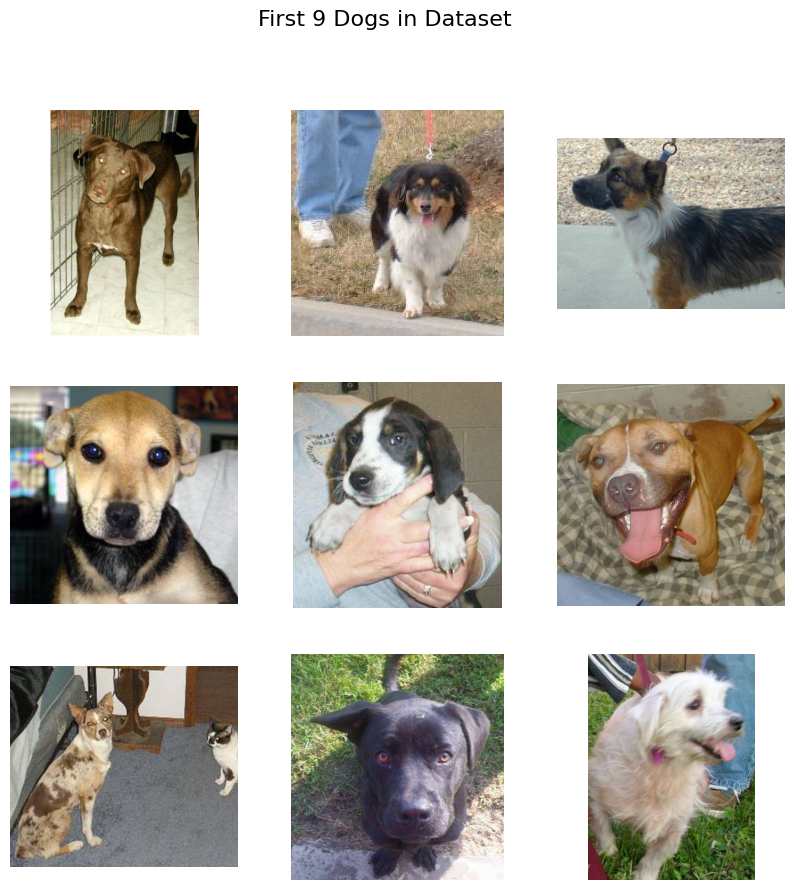

In [27]:
# Path to your images
folder = '/content/data/processed/train/dog'

plt.figure(figsize=(10, 10))
plt.suptitle("First 9 Dogs in Dataset", fontsize=16)

# The files are named dog.1.jpg, dog.2.jpg, etc.
for i in range(1, 10):
    plt.subplot(3, 3, i)
    # Construct filename
    if i == 5:
        filename = os.path.join(folder, f'dog.{i * 2}.jpg')
    else:
        filename = os.path.join(folder, f'dog.{i}.jpg')
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off') # Hide the x/y numbers for a clean look

plt.show()

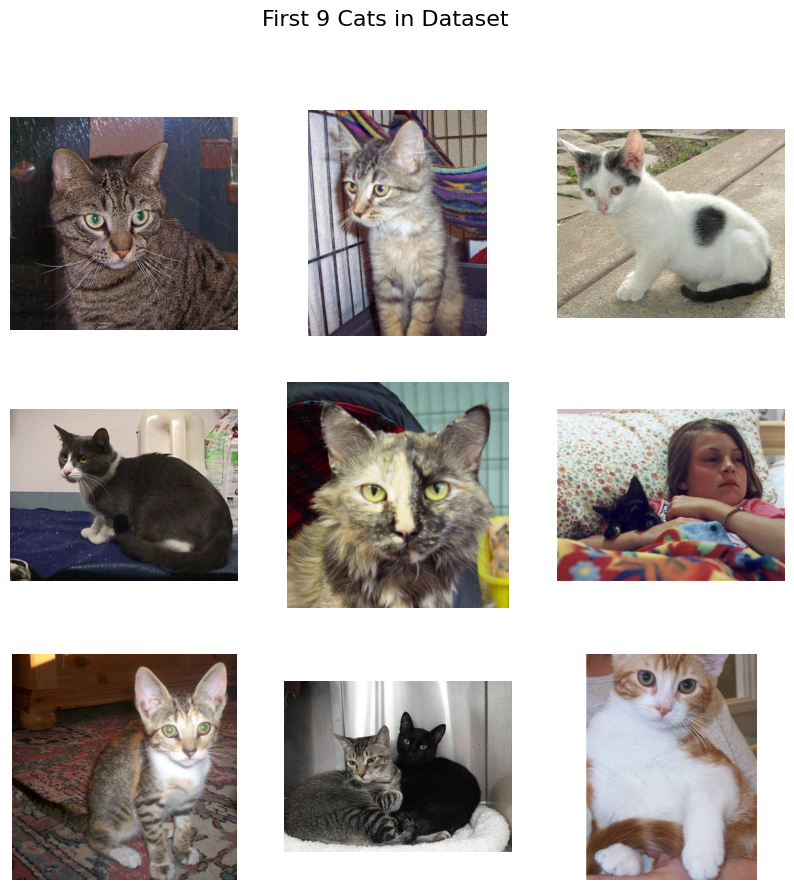

In [28]:
# Path to your images
folder = '/content/data/processed/train/cat'

plt.figure(figsize=(10, 10))
plt.suptitle("First 9 Cats in Dataset", fontsize=16)

# The files are named cat.1.jpg, cat.2.jpg, etc.
for i in range(1, 10):
    plt.subplot(3, 3, i)
    # Construct filename
    if i == 5:
        filename = os.path.join(folder, f'cat.{i * 2}.jpg')
    else:
        filename = os.path.join(folder, f'cat.{i}.jpg')
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off') # Hide the x/y numbers for a clean look

plt.show()

## 3.5 Create Generator Object

In [12]:
# 1. Create the Generator objects
# (Keeping the rescale as it's standard practice for NNs)
trdata = ImageDataGenerator(rescale=1.0/255.0)
tsdata = ImageDataGenerator(rescale=1.0/255.0)

# 2. Pass the training folder to trdata
# This creates the 'iterator' the network will use
train_data = trdata.flow_from_directory(
    directory= "/content/data/processed/train", # Path to the training folder
    target_size= (200, 200),
    batch_size= 32,
    class_mode= 'categorical'
)

# 3. Pass the test (validation) folder to tsdata
test_data = tsdata.flow_from_directory(
    directory= "/content/data/processed/test", # Path to the test/val folder
    target_size= (200, 200),
    batch_size= 32,
    class_mode= 'categorical'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Step 4. Build an ANN

In [30]:
# I will build the VGG16 "Brick by Brick"
model = Sequential()

# 1. Define the input shape separately (the new Keras 3 way)
model.add(Input(shape=(200, 200, 3)))

# Block 1: Input now matches the 200x200 generators
model.add(Conv2D(filters= 64, kernel_size= (3,3), padding= "same", activation= "relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization()) # "signal booster" between the blocks
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Block 3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Block 4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Block 5
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# The Classifier
model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=2, activation="softmax"))

# Compile
model.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 25, 25, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 107,011,650 (408.22 MB)

 Trainable params: 107,008,706 (408.21 MB)

 Non-trainable params: 2,944 (11.50 KB)

## 4.1 Check Proper Figures for Run

In [31]:
print(f"Total images found: {train_data.samples}")
print(f"Current Batch Size: {train_data.batch_size}")
print(f"Recommended steps_per_epoch: {train_data.samples // train_data.batch_size}")

Total images found: 20000
Current Batch Size: 32
Recommended steps_per_epoch: 625


## 4.2 Train the ANN / Manual (blocks by blocks)

In [ ]:
# Calculate the perfect steps
total_images = 20000 # Put your actual number here
batch_size = 32
steps = total_images // batch_size
print(f"Recommended steps_per_epoch: {steps}")

print("Starting training at:", datetime.datetime.now())

histoty = model.fit(
    train_data,
    steps_per_epoch= steps,   # Let's see 6,400 images per epoch
    validation_data= test_data,
    validation_steps= 31,
    epochs= 20              # This is the "sweet spot" for seeing progress
)

print("Training finished at:", datetime.datetime.now())

## 4.3 Optimize the above model

In [ ]:
# 1. Create the EarlyStopping object
# This stops training if the model stops getting better
early_stop = EarlyStopping(
    monitor= 'val_loss',
    patience= 5,          # Wait 5 epochs before giving up
    restore_best_weights= True
)

# 2. Create the ModelCheckpoint object
# This saves the 'Best' version of your manual bricks to your Drive
checkpoint_path = "/content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/manual_vgg_best.keras"
checkpoint = ModelCheckpoint(
    filepath= checkpoint_path,
    monitor= 'val_accuracy',
    save_best_only= True,
    verbose=1
)

# 3. Pass them to fit (Instruction says fit_generator, but fit works for both now)
history = model.fit(
    train_data,
    steps_per_epoch= 625,
    validation_data= test_data,
    validation_steps= 31,
    epochs= 20,
    callbacks= [early_stop, checkpoint] # <--- This satisfies optimized the model
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.6271 - loss: 1.1608
Epoch 1: val_accuracy improved from -inf to 0.54435, saving model to /content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/manual_vgg_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 338s 474ms/step - accuracy: 0.6272 - loss: 1.1600 - val_accuracy: 0.5444 - val_loss: 0.8916
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7827 - loss: 0.4556
Epoch 2: val_accuracy improved from 0.54435 to 0.81452, saving model to /content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/manual_vgg_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 293s 469ms/step - accuracy: 0.7828 - loss: 0.4556 - val_accuracy: 0.8145 - val_loss: 0.4049
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8666 - loss: 0.3121
Epoch 3: val_accuracy improved from 0.81452 to 0.86895, saving model to /content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/manual_vgg_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 293s 469ms/step - accuracy: 0.8666 - loss: 0.3121 -

## 4.4 Measure Model Performance

In [36]:
_, accuracy = model.evaluate(test_data)

print(f"Accuracy on test data: {accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9442 - loss: 0.1496
Accuracy on test data: 0.9398000240325928


# Step. 5 Saving Manual Model

In [35]:
model.save('/content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/vgg16_cats_dogs_final.keras')
print("Model saved successfully!")

Model saved successfully!


# Step 6. Prediction (Testing the Model)
## 6.1 Load the Saved Model
First, I'll load the model saved earlier.

In [16]:
# Load the model from the Google Drive
model_path = '/content/drive/MyDrive/ANN_DOGS_CATS_PROJECT/vgg16_cats_dogs_final.keras'
loaded_model = load_model(model_path)

print("Model loaded successfully!")
loaded_model.summary()

Model loaded successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 50, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 25, 25, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 321,029,064 (1.20 GB)

 Trainable params: 107,008,706 (408.21 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 214,017,414 (816.41 MB)

## 6.2 Preprocess and Predict on a New Image
Now, let's take a new image, preprocess it to match the input requirements of the model, and then make a prediction.

In [21]:
# Example image path (one can change this to any image one want to test)
# For demonstration, let's use an image from the processed test data
example_image_path = '/content/data/processed/test/dog/dog.1060.jpg'

# Load the image and resize it to the target size (200x200) that the model expects
img = image.load_img(example_image_path, target_size=(200, 200))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the input shape of the model (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image pixels to the same range used during training (0-1)
img_array = img_array / 255.0

# Make the prediction
predictions = loaded_model.predict(img_array)

# The output 'predictions' will be a probability distribution (e.g., [prob_cat, prob_dog])
print(f"Predictions for {example_image_path}: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predictions for /content/data/processed/test/dog/dog.1060.jpg: [[1.0875661e-04 9.9989128e-01]]


## 6.3 Interpret the Prediction
The model outputs probabilities. Let's interpret which class (dog or cat) has the higher probability.

The model predicts this image is a dog with 99.99% confidence.


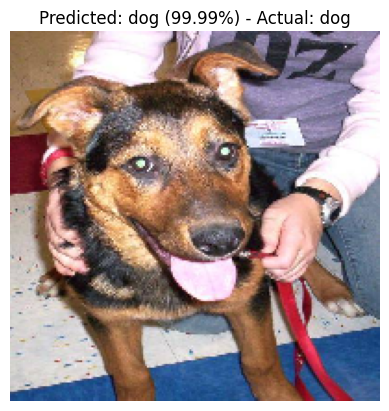

In [22]:
# Get the class labels from your ImageDataGenerator (assuming train_data is still available)
# If not, I might need to manually define them, e.g., class_labels = {'cat': 0, 'dog': 1}
class_labels = list(train_data.class_indices.keys())

# Get the predicted class index (the one with the highest probability)
predicted_class_index = np.argmax(predictions[0])

# Get the predicted class name
predicted_class_name = class_labels[predicted_class_index]

# Get the confidence of the prediction
confidence = predictions[0][predicted_class_index] * 100

print(f"The model predicts this image is a {predicted_class_name} with {confidence:.2f}% confidence.")

# Display the image for visual confirmation
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%) - Actual: {'dog' if 'dog' in example_image_path else 'cat'}")
plt.axis('off')
plt.show()

## 6.4 Now let's Test it for a Cat Image

In [23]:
example_image_path = '/content/data/processed/test/cat/cat.10825.jpg'

img = image.load_img(example_image_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = loaded_model.predict(img_array)
print(f"Predictions for {example_image_path}: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Predictions for /content/data/processed/test/cat/cat.10825.jpg: [[1.000000e+00 3.513757e-10]]


The model predicts this image is a cat with 100.00% confidence.


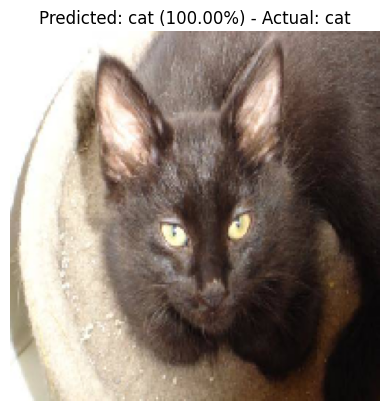

In [24]:
class_labels = list(train_data.class_indices.keys())
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(f"The model predicts this image is a {predicted_class_name} with {confidence:.2f}% confidence.")

# Display the image for visual confirmation
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%) - Actual: {'cat' if 'cat' in example_image_path else 'dog'}")
plt.axis('off')
plt.show()

# Step 7. Final Conclusion

This project successfully developed and trained a VGG16-based Convolutional Neural Network for classifying images as either 'dog' or 'cat'. I demonstrated the full pipeline from data loading and preprocessing using **ImageDataGenerator**, to building and optimizing the model with **EarlyStopping** and **ModelCheckpoint** callbacks as requested by 4GeeksAcademy instructions. The trained model achieved an accuracy of approximately **94%** on the test dataset and was successfully used to make accurate predictions on new, unseen images.

# AMAZING!!

In [27]:
example_image_path = '/content/drive/MyDrive/nala_zimyos_cat.jpg'

img = image.load_img(example_image_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = loaded_model.predict(img_array)
print(f"Predictions for {example_image_path}: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
Predictions for /content/drive/MyDrive/nala_zimyos_cat.jpg: [[0.9982274  0.00177259]]


The model predicts this image is a cat with 99.82% confidence.


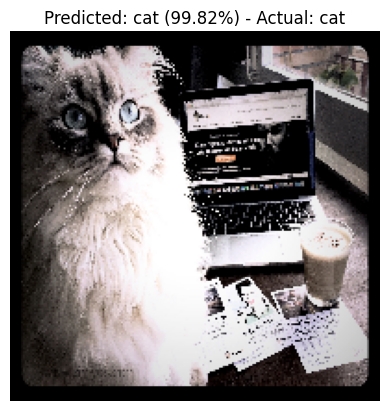

In [28]:
class_labels = list(train_data.class_indices.keys())
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index] * 100

print(f"The model predicts this image is a {predicted_class_name} with {confidence:.2f}% confidence.")

# Display the image for visual confirmation
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} ({confidence:.2f}%) - Actual: {'cat' if 'cat' in example_image_path else 'dog'}")
plt.axis('off')
plt.show()